In [7]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5
from lakeanalysis.nsidc import download_is2, read_atl03

In [2]:
dfs_all = pd.read_pickle('data/saturated_pulses_data.pkl')

In [13]:
thegroup = dfs_all.groupby('lake_nr')
summarydf = pd.DataFrame({
    'file': thegroup['fn'].first(),
    'quality': thegroup['quality'].first(),
    'sat_frac': thegroup['frac_sat'].first(),
    'sat_max': thegroup['ratio_saturation'].apply(np.percentile,**{'q': 95})
})
filtered_df = summarydf[(summarydf.sat_max > 3) & (summarydf.sat_frac>0.3)].sort_values(by='quality', ascending=False)

20 data/lakes/lake_09909316_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190115175225_02790210_006_02_gt2r_0020.h5 

-70.95678236189684 71.51003776445101
2019-01-15T17:57:57Z
ATL03_20190115175225_02790210_006_02.h5
279
gt2r
  reading in data/atl03_raw/ATL03_20190115175225_02790210_006_02_gt2r_0020.h5
  reading in beam: gt2r  --> done.


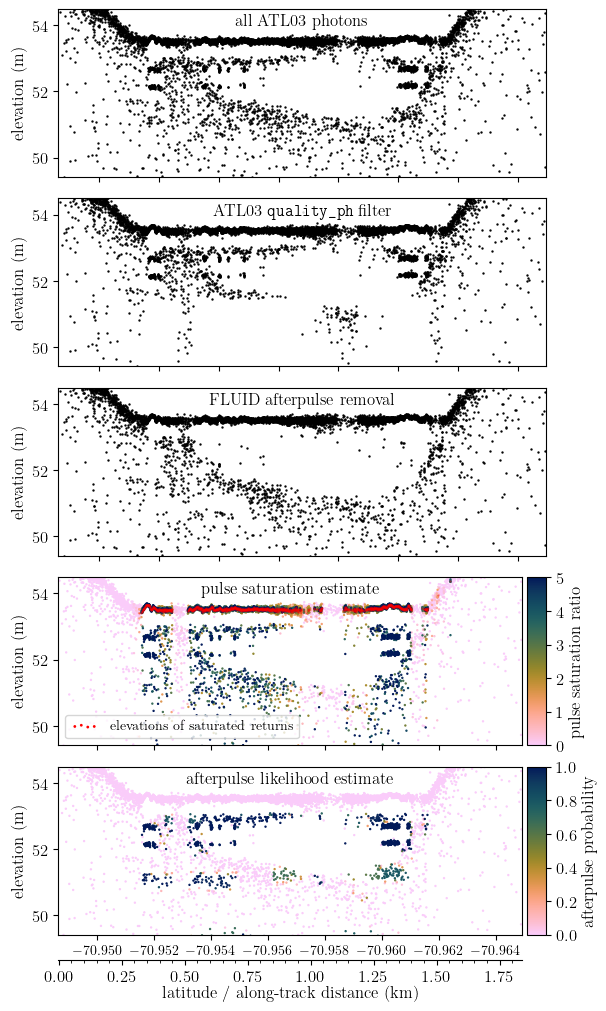

_____________________________________________________________

21 data/lakes/lake_09879690_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt2l_0019.h5 

69.01888751162573 -49.04438938557605
2019-06-17T06:45:19Z
ATL03_20190617064249_12220303_006_02.h5
1222
gt2l
  reading in data/atl03_raw/ATL03_20190617064249_12220303_006_02_gt2l_0019.h5
  reading in beam: gt2l  --> done.


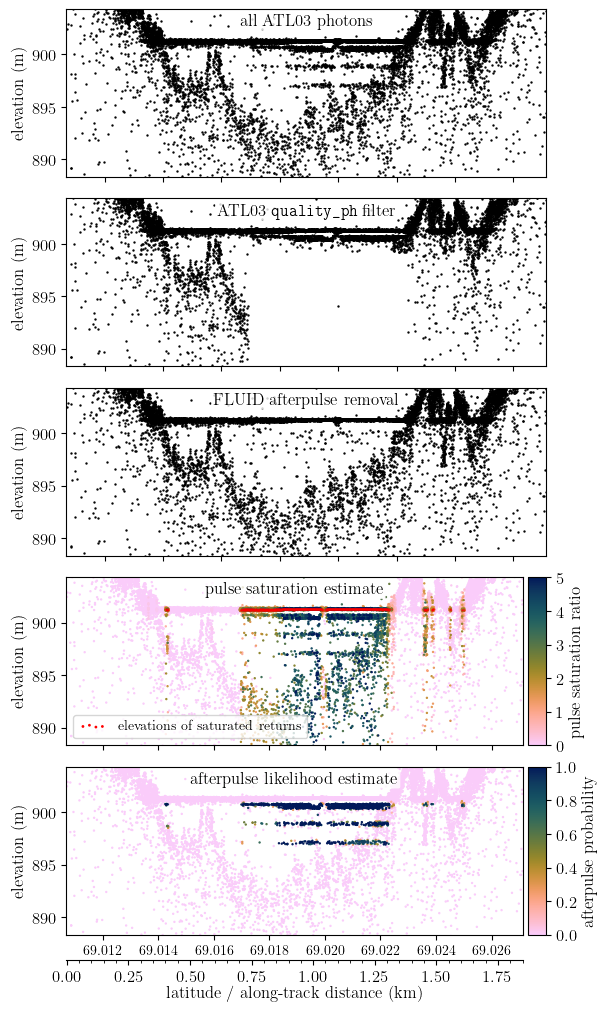

_____________________________________________________________

22 data/lakes/lake_09943900_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190822162310_08490405_006_02_gt2l_0001.h5 

71.6999275127194 -50.37072059596835
2019-08-22T16:25:22Z
ATL03_20190822162310_08490405_006_02.h5
849
gt2l
  reading in data/atl03_raw/ATL03_20190822162310_08490405_006_02_gt2l_0001.h5
  reading in beam: gt2l  --> done.


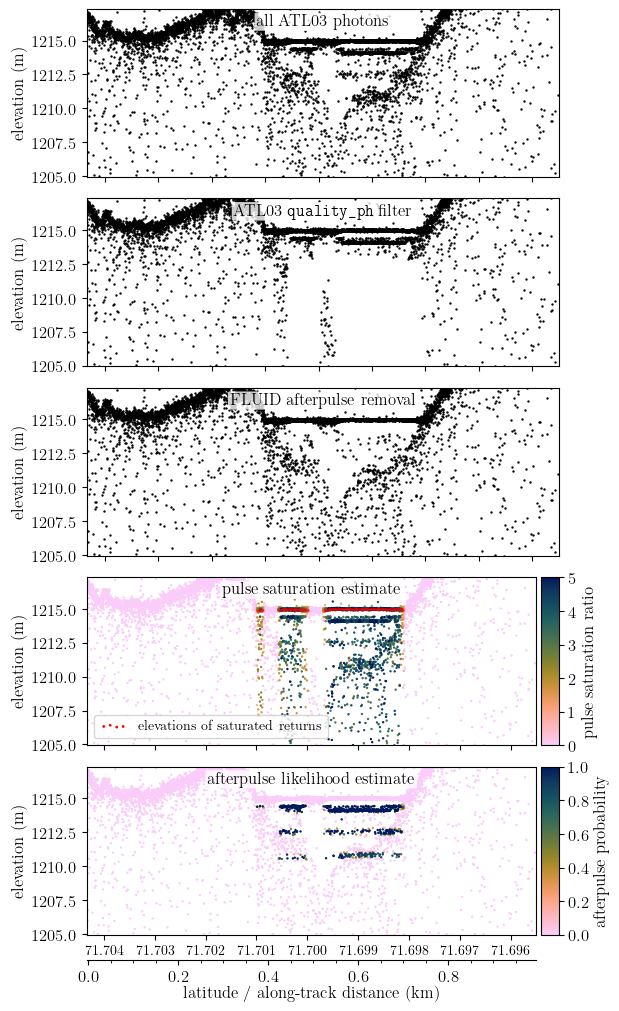

_____________________________________________________________



In [26]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})

# start = 20
# end = 40
# files = np.array(filtered_df.file)[start:end]

# files = np.array(filtered_df.file)[[1]]

files = [
    'data/lakes/lake_09909316_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190115175225_02790210_006_02_gt2r_0020.h5',
    'data/lakes/lake_09879690_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt2l_0019.h5',
    'data/lakes/lake_09943900_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190822162310_08490405_006_02_gt2l_0001.h5',
]

for i, fn in enumerate(files):

    print(start+i, fn, '\n')

    lk = dictobj(read_melt_lake_h5(fn))

    print(lk.lat, lk.lon)
    print(lk.time_utc)
    print(lk.granule_id)
    print(lk.rgt)
    print(lk.gtx)

    df = lk.photon_data
    df['pulseid'] = df.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
    df_mframe = lk.mframe_data
    xatcmin = df.xatc.min()
    df.xatc -= xatcmin
    surf_elev = lk.surface_elevation
    latmin = df.lat.min()
    latmax = df.lat.max()
    lonmin = df.lon.min()
    lonmax = df.lon.max()
    thisdate = lk.time_utc[:10]
    rgt = lk.rgt
    gtx = lk.gtx

    # download ATL03 data from NSIDC
    atl03_dir = 'data/atl03_raw'
    fn_atl03 = atl03_dir + '/' + fn[fn.find('ATL03_'):]
    if not os.path.isfile(fn_atl03):
        bbox = [lonmin, latmin, lonmax, latmax]
        granule_list = download_is2(start_date=thisdate, end_date=thisdate, rgt=rgt, boundbox=bbox, output_dir='data/atl03_raw')
        for gran in granule_list:
            if lk.granule_id[:30] in gran:
                thisfile = atl03_dir + '/processed_' + gran
                break
        os.rename(thisfile, fn_atl03)

    beams_available, ancillary, dfs = read_atl03(fn_atl03, geoid_h=True, gtxs_to_read=gtx)
    df03 = dfs[gtx]

    ylms = np.array((-1.7*lk.max_depth, 0.4*lk.max_depth)) + surf_elev
    xlms = (df.lat.min(), df.lat.max())
    
    fig, axs = plt.subplots(figsize=[6, 10], dpi=100, nrows=5, ncols=1, sharex=True)

    txt_y = 0.9
    boxprops = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none', pad=0.1)
    sz = 0.5

    ax = axs[0]
    ax.scatter(df.lat, df.h, s=sz, c='k', alpha=1)
    ax.text(0.5, txt_y, 'all ATL03 photons', transform=ax.transAxes, bbox=boxprops, ha='center')
    # ax.set_title('all ATL03 photons')

    ax = axs[1]
    dfs3 = df03[df03.qual == 0]
    ax.scatter(dfs3.lat, dfs3.h, s=sz, c='k')
    ax.text(0.5, txt_y, r'ATL03 \texttt{quality_ph} filter', transform=ax.transAxes, bbox=boxprops, ha='center')
    #ax.set_title(r'filtered by \texttt{quality_ph}')

    ax = axs[2]
    df['remove_afterpulse'] = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    dfp = df[~df.remove_afterpulse]
    scatt = ax.scatter(dfp.lat, dfp.h, s=sz, c='k', alpha=1)
    # ax.set_title('data with afterpulses removed')
    ax.text(0.5, txt_y, r'FLUID afterpulse removal', transform=ax.transAxes, bbox=boxprops, ha='center')

    ax = axs[3]
    df_sat = df.sort_values(by='sat_ratio')
    scatt = ax.scatter(df_sat.lat, df_sat.h, s=sz, alpha=1, c=df_sat.sat_ratio, cmap=cmc.batlow_r, vmin=0, vmax=5)
    dfpulse = df.groupby('pulseid').median()
    dfpulse = dfpulse[dfpulse.sat_ratio > 1.0]
    satelevs = ax.scatter(dfpulse.lat, dfpulse.sat_elev, s=0.5, c='r', alpha=0.3, label='elevations of saturated returns')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('pulse saturation ratio')
    # ax.set_title('level of pulse saturation')
    ax.text(0.5, txt_y, r'pulse saturation estimate', transform=ax.transAxes, bbox=boxprops, ha='center')
    satelevs = ax.scatter(-9999, -9999, s=1, c='r', alpha=1, label='elevations of saturated returns')
    ax.legend(handles=[satelevs], loc='lower left', fontsize=10, scatterpoints=4)

    ax = axs[4]
    df_prob = df.sort_values(by='prob_afterpulse')
    scatt = ax.scatter(df_prob.lat, df_prob.h, s=sz, alpha=1, c=df_prob.prob_afterpulse, cmap=cmc.batlow_r, vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('afterpulse probability')
    # ax.set_title('likelihood of afterpulse photons')
    ax.text(0.5, txt_y, r'afterpulse likelihood estimate', transform=ax.transAxes, bbox=boxprops, ha='center')
    ymin, ymax = ax.get_ylim()
    mframe_bounds_xatc = np.array(list(df_mframe['xatc_min']) + [df_mframe['xatc_max'].iloc[-1]]) - xatcmin
    for xmframe in mframe_bounds_xatc:
        ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)
    
    for ax in axs.flatten():
        ax.set_xlim(xlms)
        ax.set_ylim(ylms)
        ax.set_ylabel('elevation (m)')
        
    axs[4].ticklabel_format(useOffset=False, style='plain')
    axs[4].tick_params(axis='x', labelsize=10)

    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

    # flip x-axis if track is descending, to make along-track distance go from left to right
    if gt.lat.iloc[0] > gt.lat.iloc[-1]:
        for axx in axs.flatten():
            axx.set_xlim(np.flip(np.array(xlms)))

    # add along-track distance
    lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
    _lat = np.array(lx.lat)
    _xatc = np.array(lx.x10) / 1e3
    def lat2xatc(l):
        return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
    def xatc2lat(x):
        return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
    secax = ax.secondary_xaxis(-0.15, functions=(lat2xatc, xatc2lat))
    secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
    secax.tick_params(axis='both', which='major')
    secax.ticklabel_format(useOffset=False, style='plain')
    
    fig.tight_layout(pad=0.4)
    plt.savefig('plots/afterpulse_removal_%i.jpg' % (i+1), dpi=600)
    
    plt.close(fig)
    display(fig)

    print('_____________________________________________________________\n')


In [23]:
# df03
# fig, ax = plt.subplots(figsize=[6, 4], dpi=100)
# dfs3 = df03[df03.qual == 0]
# dfn3 = df03[df03.qual != 0]
# ax.scatter(dfs3.lat, dfs3.h, s=1, c='k')